In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem,Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
#----------------------------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import BayesianRidge
from scipy import stats
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("export.csv")
df



,smiles,property,value
0,[*]CC([*])C,Eat,-5.14
1,[*]CC([*])F,Eat,-5.18
2,[*]CC([*])(F)F,Eat,-5.21
3,[*]C(F)C([*])(F)F,Eat,-5.11
4,[*]CCC(F)(F)C([*])(F)F,Eat,-5.21
...,...,...,...
6260,[*]C(F)(F)C(F)(F)C(S1)=CC=C1C(S2)=CC=C2[*],eps,4.36
6261,[*]C(F)(F)C(F)(F)C(=O)O[*],eps,3.31
6262,[*]C(F)(F)C(=O)C(F)(F)C(S1)=CC=C1[*],eps,4.05
6263,[*]C(F)(F)C(=O)C(F)(F)C(C=C1)=CC=C1[*],eps,3.57


In [3]:
def canonical(smiles):
    
    a,b = [],[]
    
    for i in smiles:
        a.append(Chem.MolFromSmiles(i))
        
    for j in a:
        b.append(Chem.MolToSmiles(j))
                 
    return b

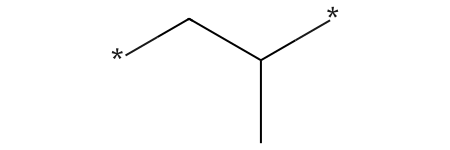

In [4]:
test = "[*]CC([*])C"
t = Chem.MolFromSmiles(test)
t

In [5]:
Chem.MolToSmiles(t)

'*CC(*)C'

In [6]:
Canon= canonical(df.smiles)
df['smiles'] = Canon
df

,smiles,property,value
0,*CC(*)C,Eat,-5.14
1,*CC(*)F,Eat,-5.18
2,*CC(*)(F)F,Eat,-5.21
3,*C(F)C(*)(F)F,Eat,-5.11
4,*CCC(F)(F)C(*)(F)F,Eat,-5.21
...,...,...,...
6260,*c1ccc(-c2ccc(C(F)(F)C(*)(F)F)s2)s1,eps,4.36
6261,*OC(=O)C(F)(F)C(*)(F)F,eps,3.31
6262,*c1ccc(C(F)(F)C(=O)C(*)(F)F)s1,eps,4.05
6263,*c1ccc(C(F)(F)C(=O)C(*)(F)F)cc1,eps,3.57


In [7]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(df['smiles'])

In [8]:
df_200 = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_200

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,7.465278,-2.404514,7.465278,0.724792,0.414720,42.081,36.033,42.046950,18,0,...,0,0,0,0,0,0,0,0,0,0
1,12.361111,-2.118056,12.361111,0.666667,0.409424,46.044,43.020,46.021878,18,0,...,0,0,0,0,0,0,0,0,0,0
2,12.027778,-2.868056,12.027778,0.854167,0.427904,64.034,62.018,64.012457,24,0,...,0,0,0,0,0,0,0,0,0,0
3,11.986111,-3.201389,11.986111,1.187500,0.441842,82.024,81.016,82.003035,30,0,...,0,0,0,0,0,0,0,0,0,0
4,12.941875,-4.883681,12.941875,1.453681,0.510440,128.068,124.036,128.024913,48,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6260,13.869230,-4.441628,13.869230,0.020181,0.737828,264.268,260.236,263.969055,84,0,...,0,0,0,0,0,0,0,2,0,0
6261,12.202454,-4.574653,12.202454,1.048588,0.534777,144.023,144.023,143.983442,52,0,...,0,0,0,0,0,0,0,0,0,0
6262,13.544977,-4.337917,13.544977,0.343579,0.694102,210.151,208.135,209.976249,70,0,...,0,0,0,0,0,0,0,1,0,0
6263,13.883065,-4.723495,13.883065,0.052901,0.684136,204.122,200.090,204.019828,74,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
dfeps = df.iloc[824:4202,:]

In [10]:
dfeps

,smiles,property,value
824,*CC(*)CC,Egc,6.5170
825,*CC(*)CCC,Egc,6.7336
826,*CC(*)CC(C)C,Egc,6.7394
827,*CC1CCC(*)C1,Egc,6.9613
828,*CC(*)CCCC1CCCCC1,Egc,6.3703
...,...,...,...
4197,*Nc1c([2H])c([2H])c(*)c([2H])c1[2H],Egc,3.3666
4198,*CCCCCC[N+](C)(C)CCC[N+](*)(C)C,Egc,0.2161
4199,*CCCCCCCC[N+](C)(C)CCCCCC[N+](*)(C)C,Egc,0.1032
4200,*CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](*)(C)C,Egc,0.1771


In [11]:
y = dfeps.value
x= df_200.iloc[824:4202,5:25]


In [12]:
y

824     6.5170
825     6.7336
826     6.7394
827     6.9613
828     6.3703
         ...  
4197    3.3666
4198    0.2161
4199    0.1032
4200    0.1771
4201    2.2084
Name: value, Length: 3378, dtype: float64

In [13]:
x = x.dropna(axis=1)
x

,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3
824,56.108000,48.044,56.062600,24,0,3.500000,4.500000,4.750000
825,70.135000,60.055,70.078250,30,0,3.000000,4.000000,4.600000
826,84.162000,72.066,84.093900,36,0,2.500000,3.333333,3.833333
827,82.146000,72.066,82.078250,34,0,2.500000,3.500000,3.833333
828,152.281000,132.121,152.156501,64,0,1.818182,2.636364,3.363636
...,...,...,...,...,...,...,...,...
4197,95.137407,86.073,95.067306,34,0,2.000000,2.714286,3.285714
4198,214.397000,184.157,214.239802,90,0,1.000000,1.733333,2.400000
4199,284.532000,244.212,284.318052,120,0,0.750000,1.250000,1.750000
4200,396.748000,340.300,396.443253,168,0,0.535714,0.892857,1.250000


In [14]:
reg1=MLPRegressor()
reg1.fit(x,y)
# score=cross_val_score(reg1,x1,y,cv=4)
pred_1 = reg1.predict(x)
result1 = x
result1['value'] = y
result1['prediction'] = pred_1.tolist()
result1.head()

,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,value,prediction
824,56.108,48.044,56.062600,24,0,3.500000,4.500000,4.750000,6.5170,7.107215
825,70.135,60.055,70.078250,30,0,3.000000,4.000000,4.600000,6.7336,6.739762
826,84.162,72.066,84.093900,36,0,2.500000,3.333333,3.833333,6.7394,6.047550
827,82.146,72.066,82.078250,34,0,2.500000,3.500000,3.833333,6.9613,5.925625
828,152.281,132.121,152.156501,64,0,1.818182,2.636364,3.363636,6.3703,5.832858


In [15]:
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
R2 =r2_score(y,pred_1)
print('R^2 of Atomization energy:', R2)

rmse = np.sqrt(mean_squared_error(y, pred_1))
print('RMSE of Atomization energy:', rmse)

R^2 of Atomization energy: 0.28471710963470764
RMSE of Atomization energy: 1.3214415226531553


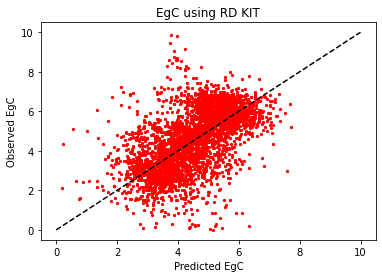

In [16]:
plt.scatter(pred_1,y,c="r",s=5)
plt.plot([0,10], [0,10] ,"k--")
plt.xlabel('Predicted EgC')
plt.ylabel('Observed EgC')
plt.title("EgC using RD KIT");

In [17]:
reg= MLPRegressor()

param_grid = {
    'hidden_layer_sizes': [20, 50],
    'max_iter': [50, 200],
}

In [18]:
grid = GridSearchCV(reg, param_grid, n_jobs= -1, cv=5)
grid.fit(x,y)

print(grid.best_params_) 

{'hidden_layer_sizes': 50, 'max_iter': 200}


In [19]:
reg2 = MLPRegressor(hidden_layer_sizes= (50), max_iter= 200)

X_train1, X_test1, y_train1, y_test1 = train_test_split(x,y,test_size=0.3)
  
reg2.fit(X_train1, y_train1) 


predictions2 = reg2.predict(X_test1)

Rmse = np.sqrt(mean_squared_error(y_test1, predictions2))
print('MSE of Atomization energy:', Rmse)

MSE of Atomization energy: 0.10326197229263077


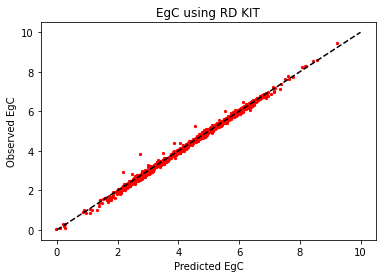

In [20]:
plt.scatter(predictions2,y_test1,c="r",s=5)
plt.plot([0,10], [0,10] ,"k--")
plt.xlabel('Predicted EgC')
plt.ylabel('Observed EgC')
plt.title("EgC using RD KIT");